In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import random
from PIL import Image
import os
from tqdm import tqdm

from utils.utils_DataVisualization import check_images, show_images
from utils.utils_DataVisualization import compare_rgb_means_per_class, compare_rgb_meanVariances_per_class, compute_pixelwise_stats, show_number_image

path_to_data_folder = "../data"
path_to_cinic10 = f"{path_to_data_folder}/CINIC-10"

In [2]:
df = pd.read_csv(f"{path_to_data_folder}/cinic10_domain_labels.csv")
df.head()

,split,category,filename,source,full_path
0,train,airplane,cifar10-train-10008.png,CIFAR-10,train/airplane/cifar10-train-10008.png
1,train,airplane,cifar10-train-10010.png,CIFAR-10,train/airplane/cifar10-train-10010.png
2,train,airplane,cifar10-train-10020.png,CIFAR-10,train/airplane/cifar10-train-10020.png
3,train,airplane,cifar10-train-10024.png,CIFAR-10,train/airplane/cifar10-train-10024.png
4,train,airplane,cifar10-train-10050.png,CIFAR-10,train/airplane/cifar10-train-10050.png


In [3]:
print("Split Distribution:")
print(df["split"].value_counts().sort_index())
print()
print("Class (Category) Distribution:")
print(df["category"].value_counts().sort_index())
print()
print("Source Domain Distribution:")
print(df["source"].value_counts())

Split Distribution:
split
test     90000
train    90000
valid    90000
Name: count, dtype: int64

Class (Category) Distribution:
category
airplane      27000
automobile    27000
bird          27000
cat           27000
deer          27000
dog           27000
frog          27000
horse         27000
ship          27000
truck         27000
Name: count, dtype: int64

Source Domain Distribution:
source
ImageNet    210000
CIFAR-10     60000
Name: count, dtype: int64


In [4]:
print("Class-wise Domain Breakdown:")
pd.crosstab(df['category'], df['source'])

Class-wise Domain Breakdown:


source,CIFAR-10,ImageNet
category,,
airplane,6000,21000
automobile,6000,21000
bird,6000,21000
cat,6000,21000
deer,6000,21000
dog,6000,21000
frog,6000,21000
horse,6000,21000
ship,6000,21000


In [5]:
# brokenImagePaths = check_images(df, path_to_cinic10)

In [6]:
print("Duplicates:", df["full_path"].duplicated().sum())

Duplicates: 0


In [7]:
print("Mean R,G,B Values per class")
print("Description: Compute Mean per image, per color channel, per class and take the mean of all mean values per color channel, per class")
compare_rgb_means_per_class(df, path_to_cinic10, n=6000) # Maximum value is 21000. Higher values to not change anything due to not having more pictures per class per source

Mean R,G,B Values per class
Description: Compute Mean per image, per color channel, per class and take the mean of all mean values per color channel, per class
Class        CIFAR-10 (R,G,B)               ImageNet (R,G,B)               Difference (R,G,B)            
----------------------------------------------------------------------------------------------------
airplane     (0.527, 0.562, 0.592)          (0.51, 0.547, 0.575)           (-0.017, -0.016, -0.017)      
automobile   (0.471, 0.455, 0.447)          (0.449, 0.436, 0.418)          (-0.022, -0.018, -0.029)      
bird         (0.489, 0.492, 0.425)          (0.471, 0.478, 0.421)          (-0.019, -0.014, -0.004)      
cat          (0.495, 0.456, 0.416)          (0.466, 0.434, 0.371)          (-0.029, -0.023, -0.045)      
deer         (0.47, 0.464, 0.377)           (0.478, 0.469, 0.385)          (0.007, 0.004, 0.008)         
dog          (0.501, 0.466, 0.418)          (0.486, 0.461, 0.4)            (-0.016, -0.005, -0.018)    

In [8]:
print("Mean R,G,B Variance Values per class")
print("Description: Compute Variance per image, per color channel, per class and take the mean of all variances per color channel, per class")
compare_rgb_meanVariances_per_class(df, path_to_cinic10, n=6000) # Maximum value is 21000. Higher values to not change anything due to not having more pictures per class per source

Mean R,G,B Variance Values per class
Description: Compute Variance per image, per color channel, per class and take the mean of all variances per color channel, per class
Class        CIFAR-10 (R,G,B)               ImageNet (R,G,B)               Difference (R,G,B)            
----------------------------------------------------------------------------------------------------
airplane     (0.062, 0.058, 0.07)           (0.056, 0.053, 0.067)          (-0.006, -0.005, -0.003)      
automobile   (0.072, 0.071, 0.076)          (0.068, 0.065, 0.071)          (-0.004, -0.005, -0.005)      
bird         (0.052, 0.049, 0.059)          (0.047, 0.045, 0.059)          (-0.005, -0.004, -0.0)        
cat          (0.066, 0.063, 0.066)          (0.059, 0.054, 0.056)          (-0.007, -0.009, -0.01)       
deer         (0.047, 0.042, 0.044)          (0.051, 0.047, 0.05)           (0.004, 0.005, 0.006)         
dog          (0.063, 0.059, 0.062)          (0.06, 0.057, 0.061)           (-0.002, -0.003, 

In [9]:
category = "airplane"
channel = "B"
numberOfSamples = 5000

cifar_mean_img, cifar_variance_img = compute_pixelwise_stats(df, path_to_cinic10, n=numberOfSamples, category=category, source="CIFAR-10")
imagenet_mean_img, imagenet_variance_img = compute_pixelwise_stats(df, path_to_cinic10, n=numberOfSamples, category=category, source="ImageNet")

mean_diff = imagenet_mean_img - cifar_mean_img
variance_diff = imagenet_variance_img - cifar_variance_img

Computing variance ['airplane'] | CIFAR-10: 5000it [00:02, 2148.53it/s]
Computing variance ['airplane'] | ImageNet: 5000it [00:03, 1537.67it/s]


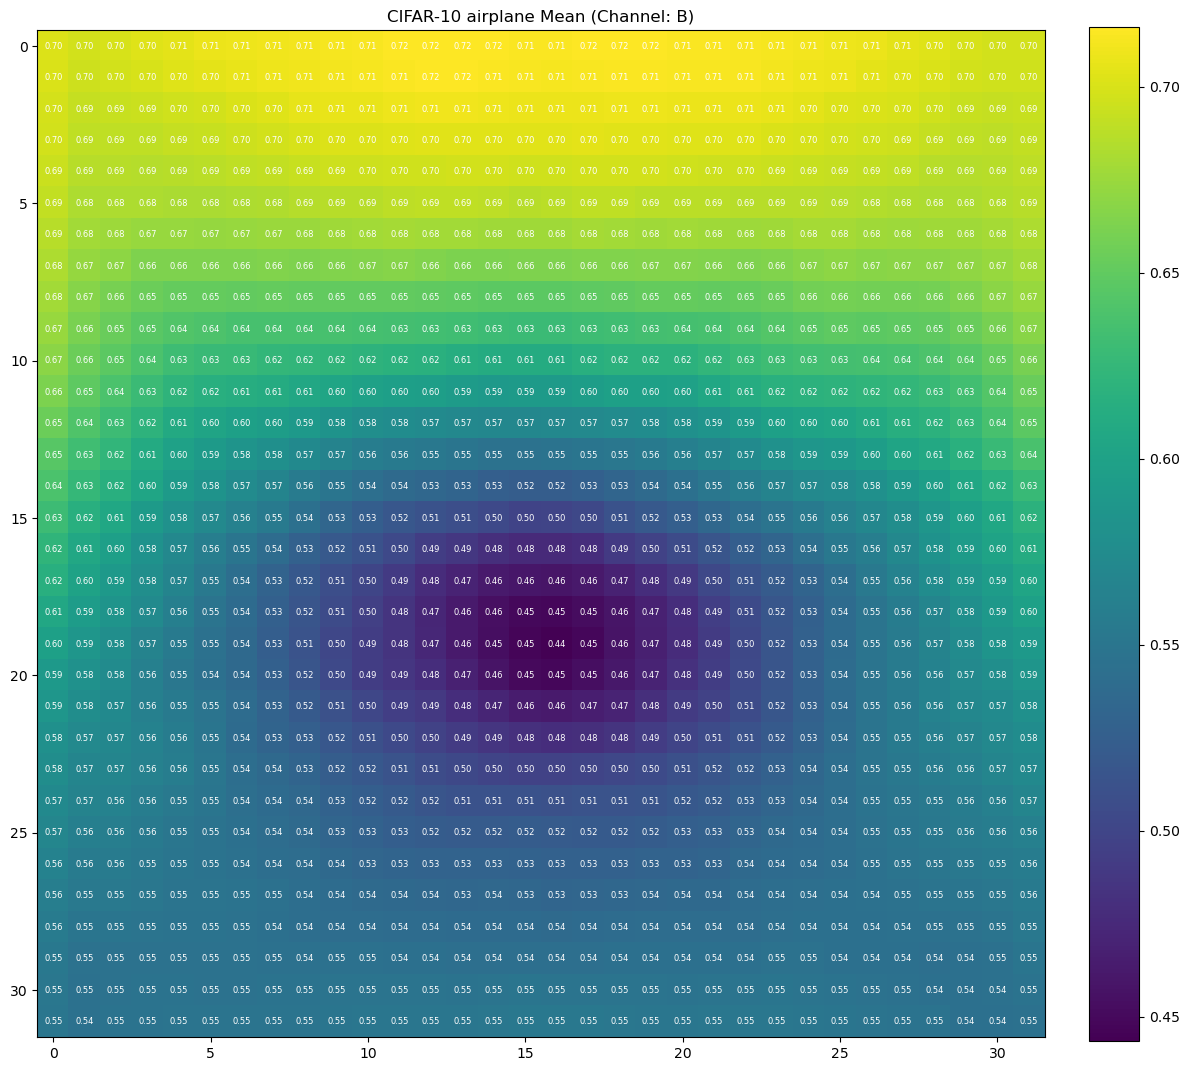

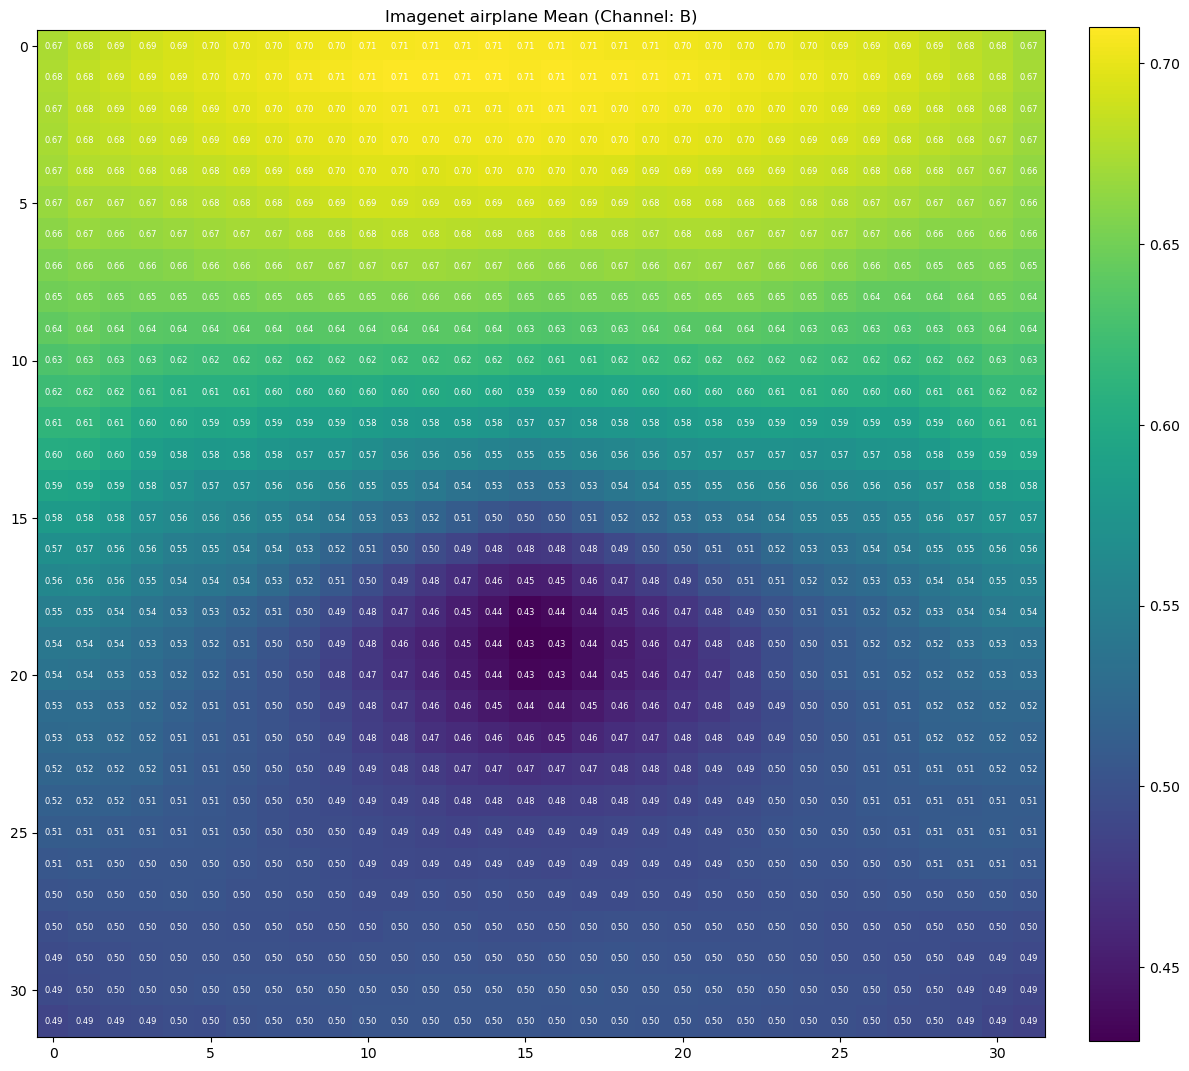

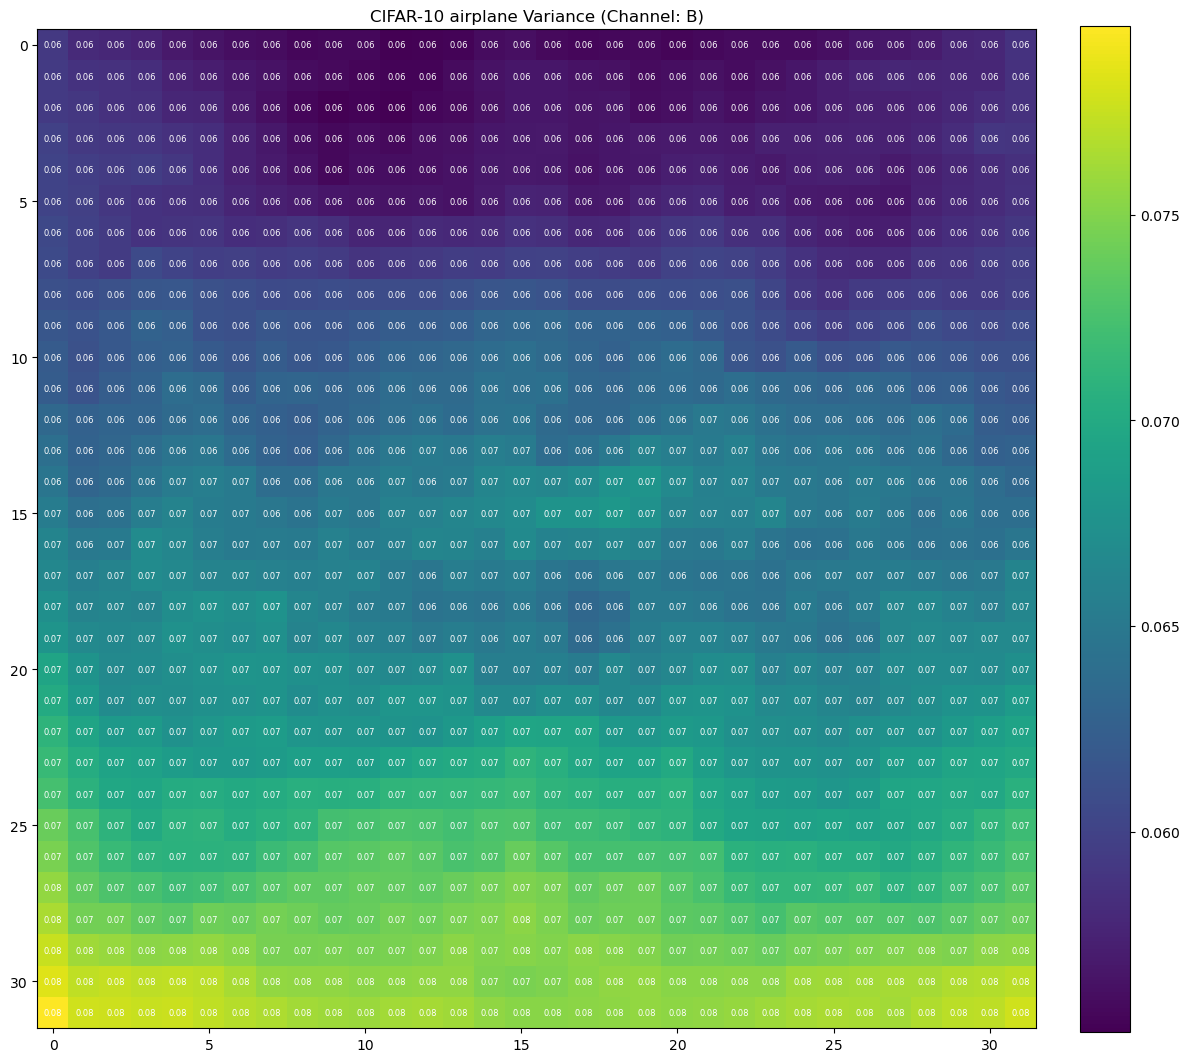

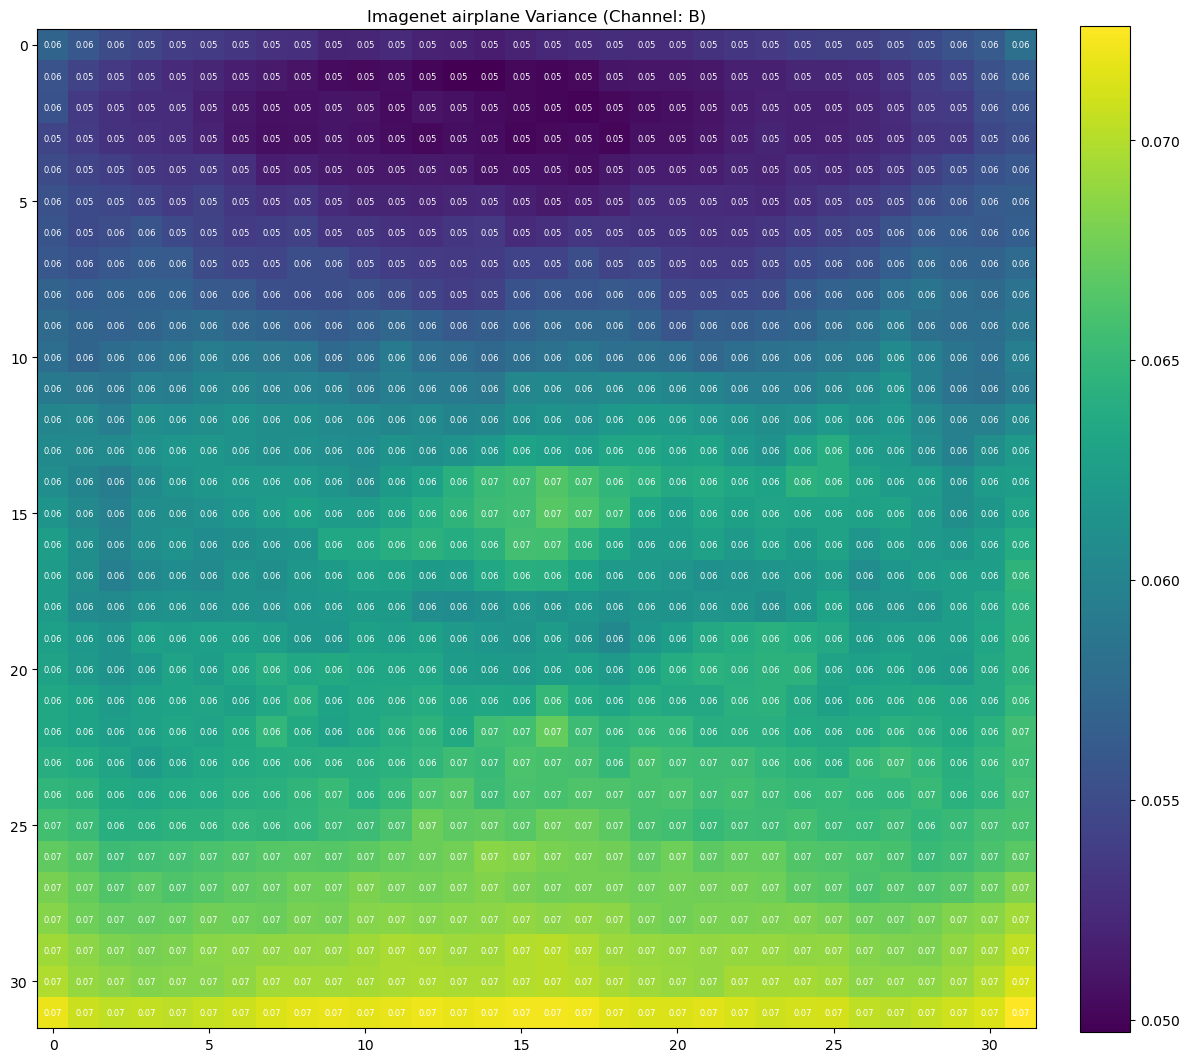

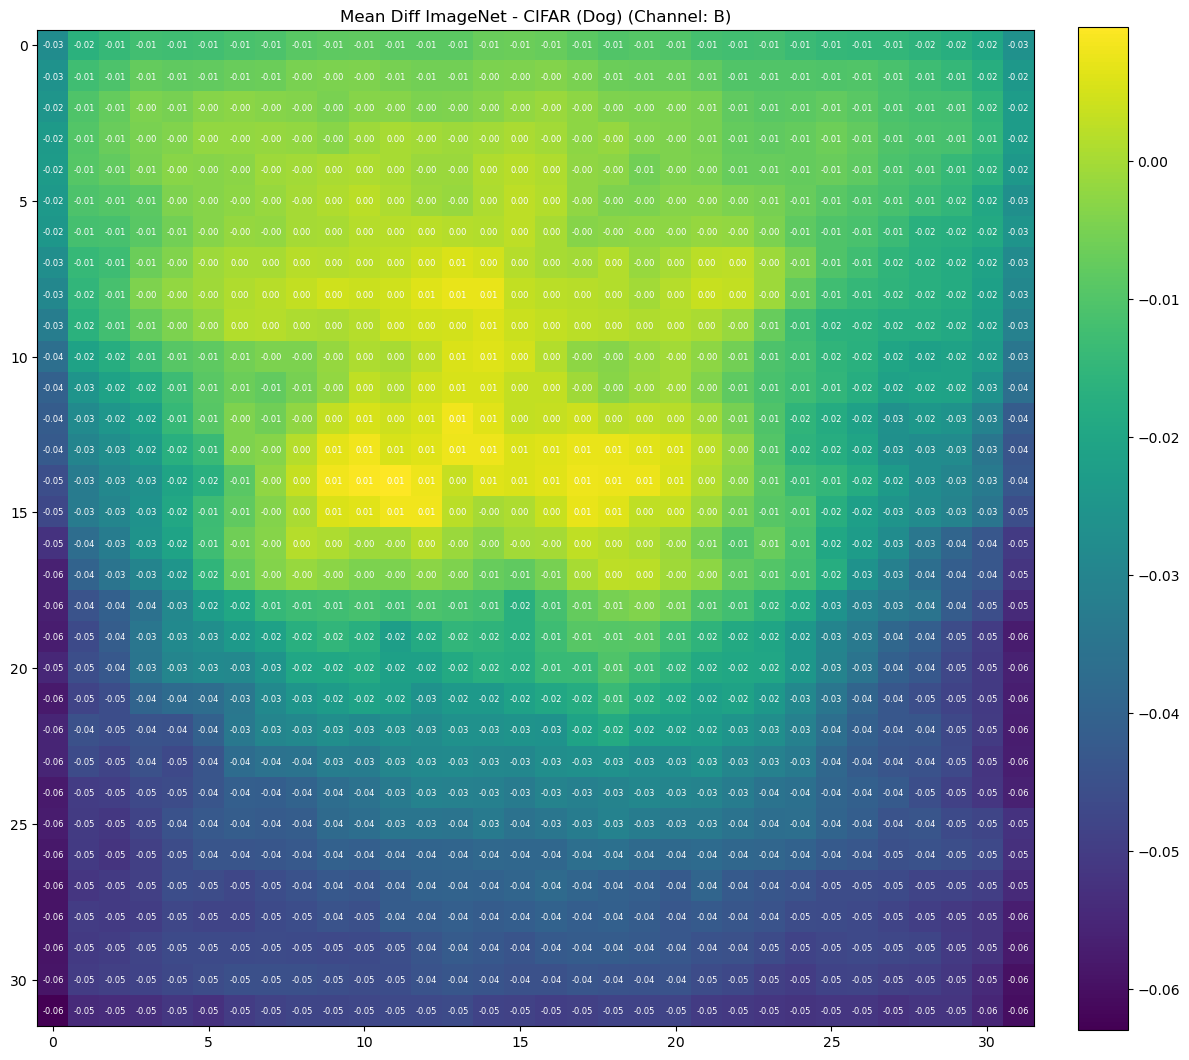

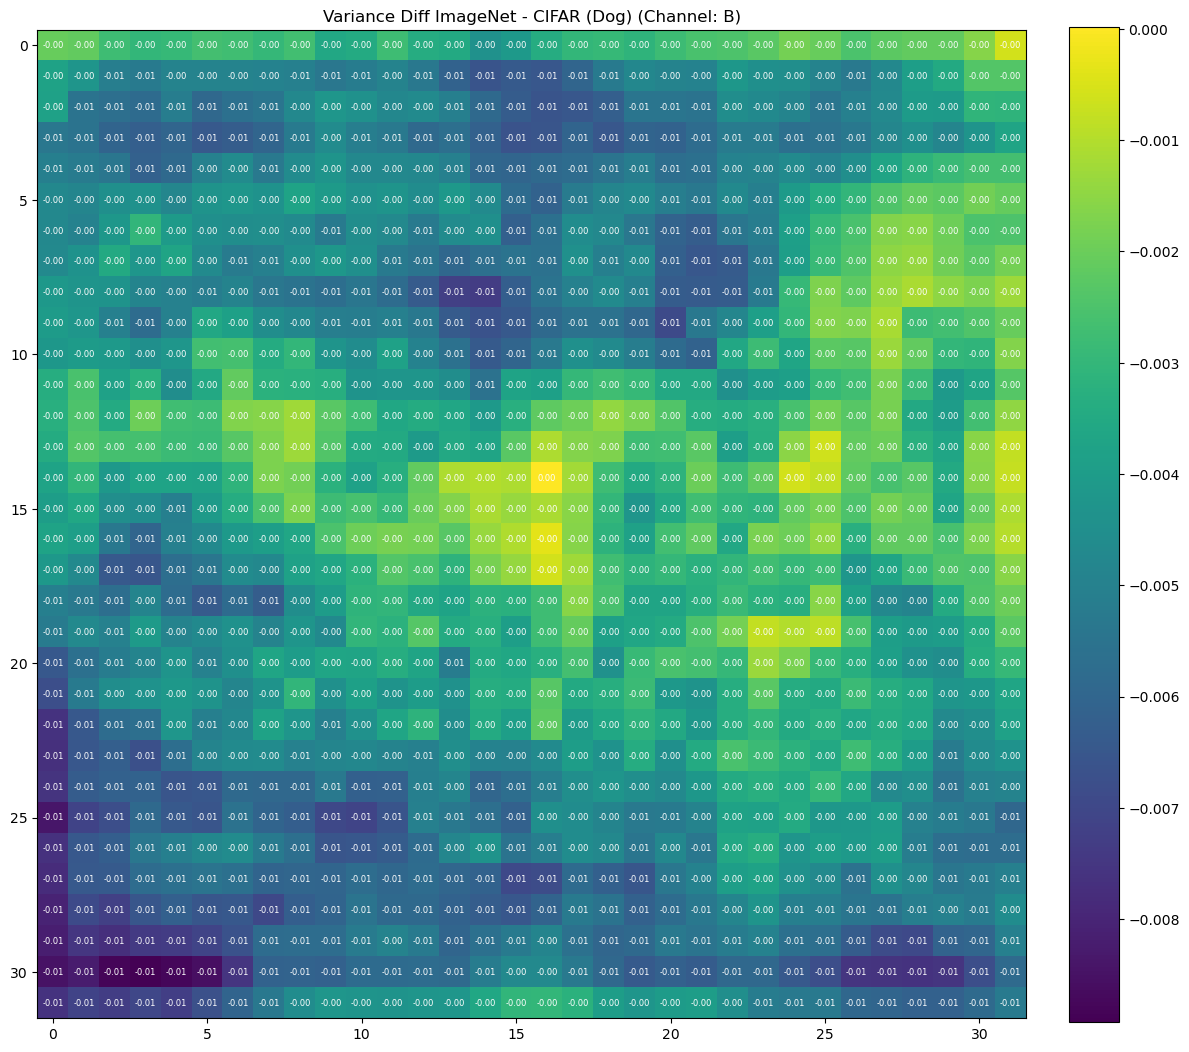

In [10]:
show_number_image(cifar_mean_img, title=f"CIFAR-10 {category} Mean", channel=channel)
show_number_image(imagenet_mean_img, title=f"Imagenet {category} Mean", channel=channel)

show_number_image(cifar_variance_img, title=f"CIFAR-10 {category} Variance", channel=channel)
show_number_image(imagenet_variance_img, title=f"Imagenet {category} Variance", channel=channel)

show_number_image(mean_diff, title="Mean Diff ImageNet - CIFAR (Dog)", channel=channel)
show_number_image(variance_diff, title="Variance Diff ImageNet - CIFAR (Dog)", channel=channel)

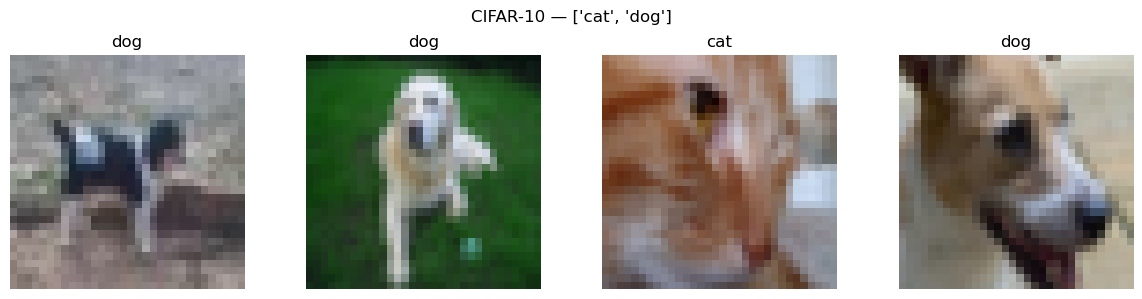

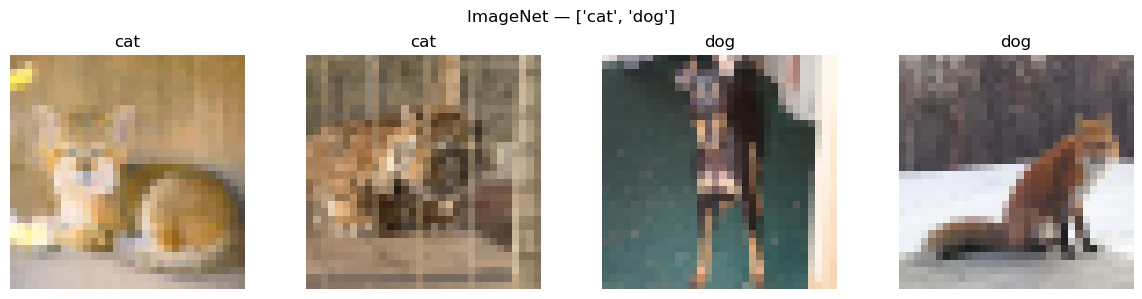

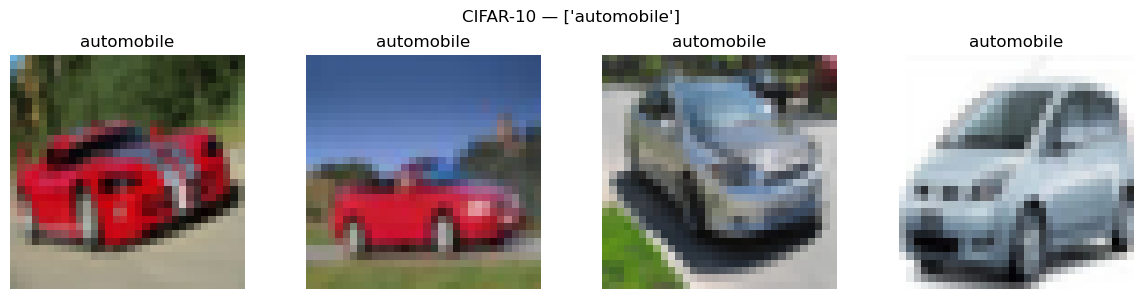

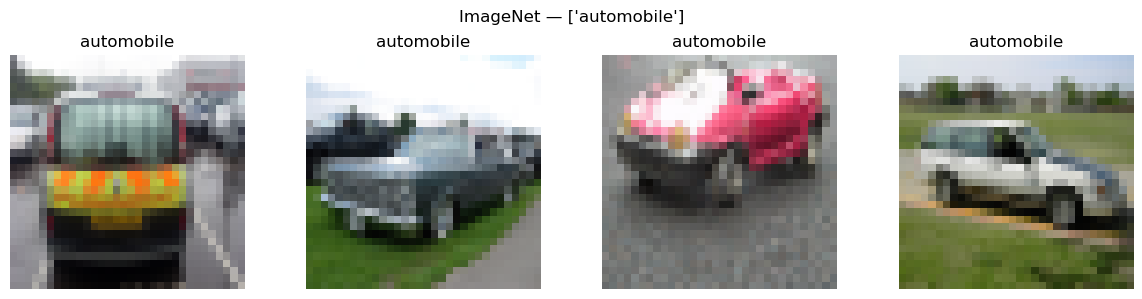

In [11]:
# Show 7 random CIFAR-10 images from ["cat", "dog"]
show_images(df, path_to_cinic10, label="CIFAR-10", n=4, random_state=40, class_filter=["cat", "dog"])

# Show 7 random ImageNet images from ["cat", "dog"]
show_images(df, path_to_cinic10, label="ImageNet", n=4, random_state=40, class_filter=["cat", "dog"])

# Show 7 random CIFAR-10 images from ["automobile"]
show_images(df, path_to_cinic10, label="CIFAR-10", n=4, random_state=50, class_filter= "automobile")

# Show 7 random ImageNet images from ["automobile"]
show_images(df, path_to_cinic10, label="ImageNet", n=4, random_state=50, class_filter= "automobile")

